In [298]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_predict, StratifiedKFold

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [299]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna

import warnings # Para ignorar los warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import cross_val_score, train_test_split  # Para dividir los datos en train y test
from sklearn.utils import resample # Ponemos las mismas longitudes a cada variable

# Librerias para el modelo
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

# Librerias para valorar el modelo
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc

In [300]:
df = pd.read_excel('C:/Users/jor14/Desktop/ALLaugmented_featureauto.xlsx')

In [301]:
# Extraemos los datos (variable dependiente y variables independientes)
X = df.drop('Result', axis=1)
y = df['Result']

In [302]:
print(X.shape)

(68, 10)


In [303]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, train_size=0.9, stratify=y, random_state=42)

In [304]:
print(X_train.shape)

(61, 10)


In [305]:
print(X_test.shape)

(7, 10)


In [306]:
# Ahora nuestras variables seran vectores
y_train = y_train.values
X_test = X_test.values
X_train = X_train.values
y_test = y_test.values

In [307]:
nombres_caracteristicas = X.columns
print(nombres_caracteristicas)

Index(['PCR', 'logarithm_glcm_Autocorrelation', 'Barthel_scale_1',
       'Lymphocytes', 'lbp-3D-k_glszm_LargeAreaEmphasis',
       'original_glszm_SmallAreaLowGrayLevelEmphasis',
       'original_shape_MajorAxisLength',
       'wavelet-HLH_glszm_LargeAreaLowGrayLevelEmphasis',
       'wavelet-HHH_firstorder_Median', 'logarithm_glcm_Contrast'],
      dtype='object')


In [308]:
clf = RandomForestClassifier(n_estimators=100, random_state=42)


In [309]:
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [310]:
feature_scores = pd.Series(clf.feature_importances_, index=X.columns).sort_values(ascending=False)
n=9

In [311]:
print(feature_scores)

PCR                                                0.224915
wavelet-HHH_firstorder_Median                      0.184684
Lymphocytes                                        0.105521
wavelet-HLH_glszm_LargeAreaLowGrayLevelEmphasis    0.089022
logarithm_glcm_Autocorrelation                     0.085003
logarithm_glcm_Contrast                            0.077827
lbp-3D-k_glszm_LargeAreaEmphasis                   0.073050
original_glszm_SmallAreaLowGrayLevelEmphasis       0.071324
original_shape_MajorAxisLength                     0.067447
Barthel_scale_1                                    0.021209
dtype: float64


In [312]:
selected_features = feature_scores.index.values[:n]
print(selected_features)

cols_index = [X.columns.tolist().index(col) for col in selected_features]

['PCR' 'wavelet-HHH_firstorder_Median' 'Lymphocytes'
 'wavelet-HLH_glszm_LargeAreaLowGrayLevelEmphasis'
 'logarithm_glcm_Autocorrelation' 'logarithm_glcm_Contrast'
 'lbp-3D-k_glszm_LargeAreaEmphasis'
 'original_glszm_SmallAreaLowGrayLevelEmphasis'
 'original_shape_MajorAxisLength']


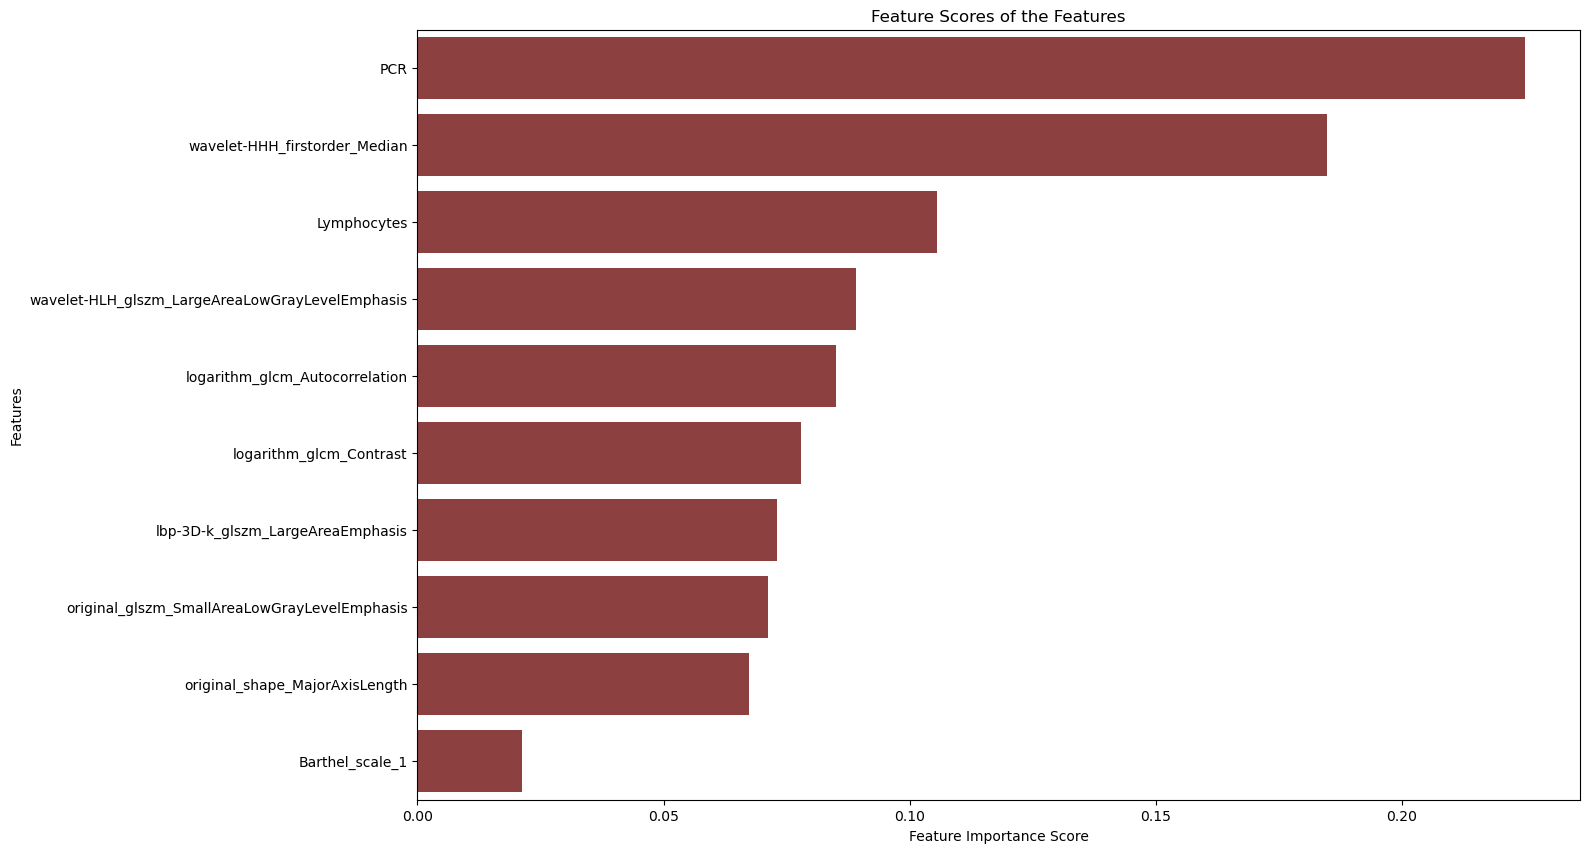

In [313]:
# Suponiendo que feature_scores es una Serie de pandas con nombres de características como índice y puntuaciones como valores
f, ax = plt.subplots(figsize=(15, 10))

# Crear el barplot con color granate y transparencia
sns.barplot(x=feature_scores.values, y=feature_scores.index, ax=ax, color='maroon', alpha= 0.8)  # (R, G, B, A) para RGBA

# Ajustar título y etiquetas
ax.set_title("Feature Scores of the Features")
ax.set_xlabel("Feature Importance Score")
ax.set_ylabel("Features")

# Mostrar gráfico
plt.show()

In [314]:
X_train = X_train[:, cols_index]
X_test = X_test[:, cols_index]

In [315]:
from sklearn.metrics import make_scorer, confusion_matrix
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier

def specificity(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tn = cm[0, 0]  # Verdaderos Negativos
    fp = cm[0, 1]  # Falsos Positivos
    return tn / (tn + fp) if (tn + fp) > 0 else 0

def objective(trial):
    # Definir los hiperparámetros que Optuna ajustará
    n_estimators = trial.suggest_int('n_estimators', 10, 200)
    max_depth = trial.suggest_int('max_depth', 2, 32)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 4)
    bootstrap = trial.suggest_categorical('bootstrap', [True, False])

    # Definir el modelo con los hiperparámetros sugeridos
    model = RandomForestClassifier(
        n_estimators=n_estimators, 
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        bootstrap=bootstrap,
        random_state=42
    )

    # Evaluar el modelo utilizando validación cruzada
    cv = StratifiedKFold(n_splits=5)
    scorer = make_scorer(specificity, greater_is_better=True)
    
    # Usar cross_val_score para evaluar el modelo con la métrica de especificidad
    scores = cross_val_score(model, X, y, cv=cv, scoring=scorer)
    
    return scores.mean()


In [316]:
study = optuna.create_study(direction='maximize')  # Maximizar la precisión
study.optimize(objective, n_trials=50)  # Realiza 50 pruebas para encontrar los mejores hiperparámetros

# Imprimir los mejores parámetros encontrados por Optuna
print(f"Mejores parámetros: {study.best_params}")
print(f"Mejor puntuación (accuracy): {study.best_value}")

[I 2024-09-03 19:57:20,437] A new study created in memory with name: no-name-6a3029c2-3024-449e-b85c-23c8521ab47b
[I 2024-09-03 19:57:21,364] Trial 0 finished with value: 0.7142857142857142 and parameters: {'n_estimators': 146, 'max_depth': 25, 'min_samples_split': 7, 'min_samples_leaf': 2, 'bootstrap': True}. Best is trial 0 with value: 0.7142857142857142.
[I 2024-09-03 19:57:21,812] Trial 1 finished with value: 0.6857142857142857 and parameters: {'n_estimators': 103, 'max_depth': 6, 'min_samples_split': 8, 'min_samples_leaf': 4, 'bootstrap': False}. Best is trial 0 with value: 0.7142857142857142.
[I 2024-09-03 19:57:22,128] Trial 2 finished with value: 0.6571428571428571 and parameters: {'n_estimators': 54, 'max_depth': 7, 'min_samples_split': 8, 'min_samples_leaf': 4, 'bootstrap': True}. Best is trial 0 with value: 0.7142857142857142.
[I 2024-09-03 19:57:22,374] Trial 3 finished with value: 0.7428571428571428 and parameters: {'n_estimators': 52, 'max_depth': 11, 'min_samples_split':

Mejores parámetros: {'n_estimators': 109, 'max_depth': 29, 'min_samples_split': 4, 'min_samples_leaf': 1, 'bootstrap': False}
Mejor puntuación (accuracy): 0.7999999999999999


In [317]:
best_params = study.best_params
best_model = RandomForestClassifier(**best_params, random_state=42)

# Entrenar el modelo con todos los datos disponibles
best_model.fit(X_train, y_train)

# Si tienes un conjunto de prueba separado, evalúalo allí:
# y_probs = best_model.predict_proba(X_test)[:, 1]
# fpr, tpr, thresholds = roc_curve(y_test, y_probs)

# Si no, usa validación cruzada:
y_probs = cross_val_predict(best_model, X_train, y_train, cv=StratifiedKFold(n_splits=5), method="predict")
fpr, tpr, thresholds = roc_curve(y_train, y_probs)

In [318]:
roc_auc = auc(fpr, tpr)

In [319]:
def print_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    print('True positive = ', cm[1][1])
    print('False positive = ', cm[0][1])
    print('False negative = ', cm[1][0])
    print('True negative = ', cm[0][0])

In [320]:
# Generar la matriz de confusión
mat_con = confusion_matrix(y_train, y_probs)
mat_con = np.flipud(mat_con)
mat_con = np.fliplr(mat_con)

In [321]:
print('Accuracy: {:.2f}'.format(accuracy_score(y_train, y_probs)))
print('Precisión: {:.2f}'.format(precision_score(y_train, y_probs)))
print('Recall: {:.2f}'.format(recall_score(y_train, y_probs)))
print('F1 Score: {:.2f}'.format(f1_score(y_train, y_probs)))
print('AUC: {:.2f}'.format(auc(fpr, tpr)))
print('Matriz de confusión:')
print(mat_con)
print_confusion_matrix(y_train, y_probs)

Accuracy: 0.80
Precisión: 0.85
Recall: 0.74
F1 Score: 0.79
AUC: 0.80
Matriz de confusión:
[[23  8]
 [ 4 26]]
True positive =  23
False positive =  4
False negative =  8
True negative =  26


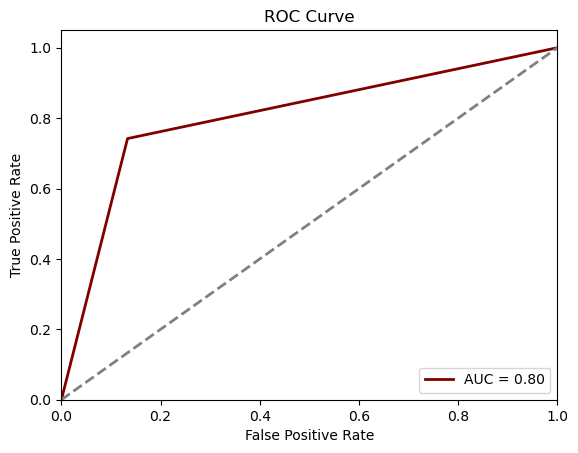

In [322]:
plt.figure()
plt.plot(fpr, tpr, color='maroon', lw=2, label='AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()


In [323]:
# Convertir probabilidades en etiquetas binarias usando un umbral
y_pred = (y_probs >= 0.5).astype(int)

# Obtener la matriz de confusión
tn, fp, fn, tp = confusion_matrix(y_train, y_pred).ravel()

# Calcular la especificidad
especificidad = tn / (tn + fp)

In [324]:
print(f'Especificidad: {especificidad:.2f}')

Especificidad: 0.87


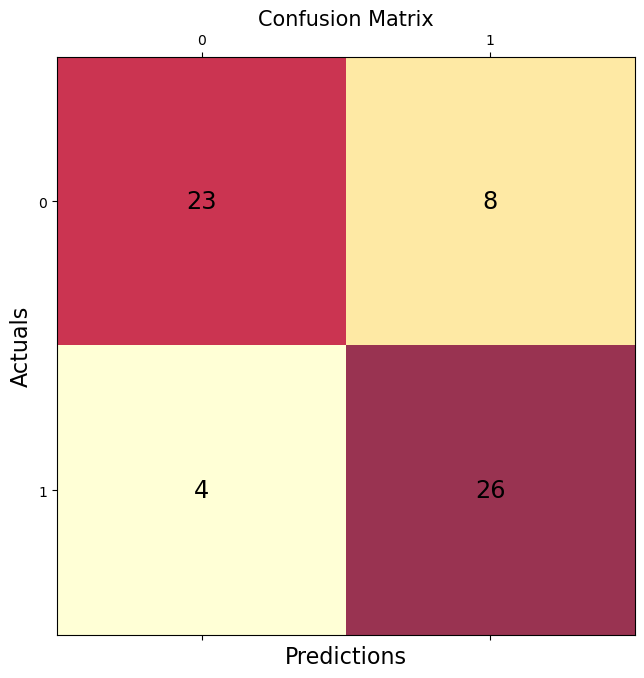

In [325]:
# Setting the attributes
fig, px = plt.subplots(figsize=(7.5, 7.5))

px.matshow(mat_con, cmap=plt.cm.YlOrRd, alpha=0.8)
for m in range(mat_con.shape[0]):
    for n in range(mat_con.shape[1]):
        px.text(x=m,y=n,s=mat_con[n, m], va='center', ha='center', size='xx-large')

# Sets the labels
plt.xlabel('Predictions', fontsize=16)
plt.ylabel('Actuals', fontsize=16)
plt.title('Confusion Matrix', fontsize=15)
plt.show()

In [327]:

# Obtener las probabilidades predichas para la clase positiva en el conjunto de prueba
y_probs = best_model.predict(X_test)

# Calcular la curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_probs)

In [328]:
def print_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    print('True positive = ', cm[1][1])
    print('False positive = ', cm[0][1])
    print('False negative = ', cm[1][0])
    print('True negative = ', cm[0][0])

In [329]:
mat_con = (confusion_matrix(y_test, y_probs))
mat_con = np.flipud(mat_con)
mat_con = np.fliplr(mat_con)

In [330]:
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, y_probs)))
print('Precisión: {:.2f}'.format(precision_score(y_test, y_probs)))
print('Recall: {:.2f}'.format(recall_score(y_test, y_probs)))
print('F1 Score: {:.2f}'.format(f1_score(y_test, y_probs)))
print('AUC: {:.2f}'.format(roc_auc))
print('Matriz de confusión:')
print(mat_con)
print_confusion_matrix(y_test, y_probs)

Accuracy: 0.71
Precisión: 0.60
Recall: 1.00
F1 Score: 0.75
AUC: 0.80
Matriz de confusión:
[[3 0]
 [2 2]]
True positive =  3
False positive =  2
False negative =  0
True negative =  2


In [331]:

# Obtener la matriz de confusión
tn, fp, fn, tp = confusion_matrix(y_test, y_probs).ravel()

# Calcular la especificidad
especificidad = tn / (tn + fp)

print(f'Especificidad: {especificidad:.2f}')

Especificidad: 0.50


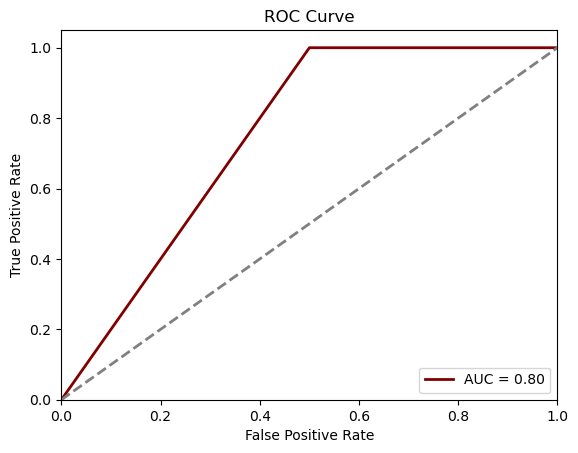

In [332]:
plt.figure()
plt.plot(fpr, tpr, color='maroon', lw=2, label='AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

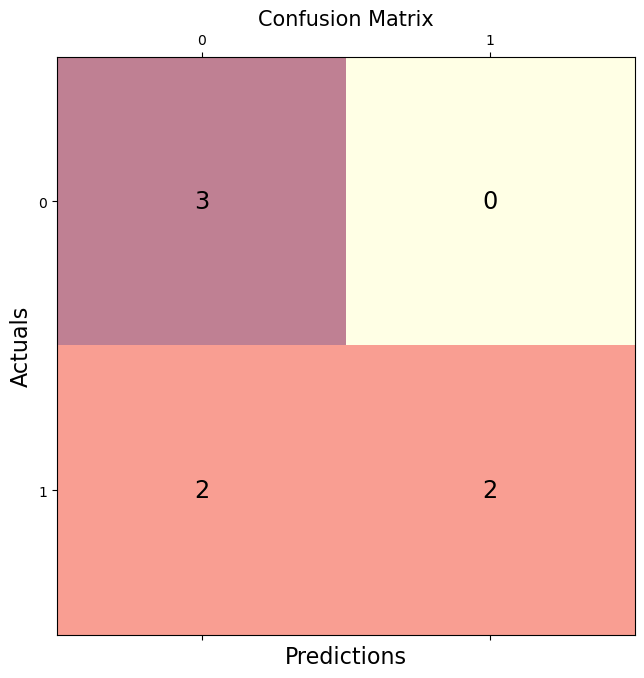

In [333]:
# Setting the attributes
fig, px = plt.subplots(figsize=(7.5, 7.5))
px.matshow(mat_con, cmap=plt.cm.YlOrRd, alpha=0.5)
for m in range(mat_con.shape[0]):
    for n in range(mat_con.shape[1]):
        px.text(x=m,y=n,s=mat_con[n, m], va='center', ha='center', size='xx-large')

# Sets the labels
plt.xlabel('Predictions', fontsize=16)
plt.ylabel('Actuals', fontsize=16)
plt.title('Confusion Matrix', fontsize=15)
plt.show()

In [352]:
train_sizes, train_scores, test_scores = learning_curve(
    best_model, X_train, y_train, cv=5, n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10), scoring='recall'
)

In [353]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)


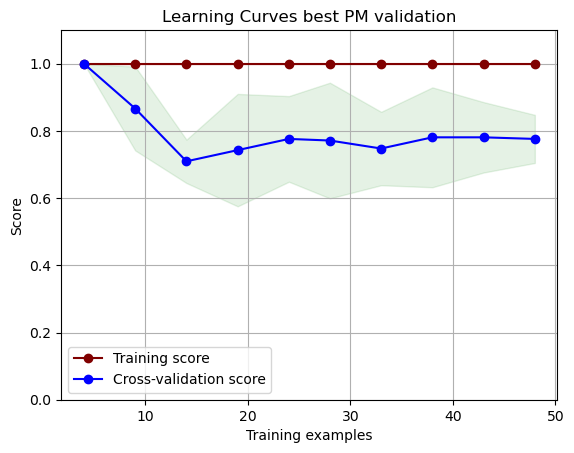

In [359]:
plt.figure()
plt.title("Learning Curves best PM validation")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.ylim(0, 1.1)
plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")

plt.plot(train_sizes, train_scores_mean, 'o-', color="maroon", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="blue", label="Cross-validation score")

plt.legend(loc="best")
plt.show()